# Notebook 4: Decision Trees | Habitable Planets

### This notebook is adapted from our course textbook.

It accompanies Chapter 3 of the book.

Data for this exercise come from [the Planet Habitability Lab](https://phl.upr.edu/projects/habitable-exoplanets-catalog).

Copyright: Viviana Acquaviva (2023)

License: [BSD-3-clause](https://opensource.org/license/bsd-3-clause/)

___

#### Please upload your completed notebook to Canvas as an .ipynb file
#### Title the file as: LastName_notebook4.ipynb

### Original work statement:

Please write your name and the names of your collaborators in this cell.

Please be sure to cite sources along the way as appropriate.

### Your name:
#### Collaborators:

You can edit this notebook directly by adding code and text cells as needed. As always, begin by importing the necessary packages.


---

In [ ]:
import pandas as pd
import numpy as np

import sklearn.tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import KFold, StratifiedKFold

from scipy import stats

In [ ]:
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import LearningCurveDisplay

# Problem 1: Preliminary data exploration and visualization

## 1.1 load the exoplanet.csv file
### We use a selection of data from [the Planet Habitability Lab](https://phl.upr.edu/projects/habitable-exoplanets-catalog).

This file contains data from an exoplanet catalog.

The file contains 4 columns:
- The first column, S_MASS, is star mass  in units of $M_{\odot}$
- The second column, P_PERIOD, is the orbital period of the planet in [days]
- The third column, P_DISTANCE, is the distance from the planet to the host star in [AU]
- The fourth column, P_HABITABLE, has a binary value for whether the planet is habitable or not. 0-not habitable, 1-habitable.


In [ ]:
df = pd.read_csv('exoplanet.csv')

In [ ]:
df.head()

,S_MASS,P_PERIOD,P_DISTANCE,P_HABITABLE
0,2.70,326.03000,1.324418,0
1,2.78,516.21997,1.534896,0
2,2.20,185.84000,0.830000,0
3,0.90,1773.40000,3.130558,0
4,1.08,798.50000,2.043792,0


In [ ]:
df.describe()

,S_MASS,P_PERIOD,P_DISTANCE,P_HABITABLE
count,3171.000000,3171.000000,3171.000000,3171.000000
mean,0.995042,293.162284,0.530662,0.016399
std,0.346681,1329.901272,1.360364,0.127023
min,0.020000,0.090706,0.004408,0.000000
25%,0.820000,4.172511,0.050409,0.000000
50%,0.970000,11.541820,0.096800,0.000000
75%,1.130000,53.564227,0.270655,0.000000
max,4.260000,43500.000000,25.426153,1.000000


Here is a way of showing summary statistics by class.

In [ ]:
df.groupby('P_HABITABLE').count()

,S_MASS,P_PERIOD,P_DISTANCE
P_HABITABLE,,,
0,3119,3119,3119
1,52,52,52


## 1.2 Create variables to hold the features and targets
Your features will be 'S_MASS', 'P_PERIOD', 'P_DISTANCE'.

Your target will be 'P_HABITABLE'.

In [ ]:
final_features = (df[['S_MASS', 'P_PERIOD', 'P_DISTANCE']] ).to_numpy()

In [ ]:
targets = (df.P_HABITABLE).to_numpy()

## 1.3 Make a histogram of the features.
note: take a look at df.head() to print out the first 5 rows, you may need to make three separate histograms if the ranges of the features are too different!

Non-pro tip: when you plot a distribution in a histogram, and the x-range seems unnecessarily large, it means that there are outliers! :)

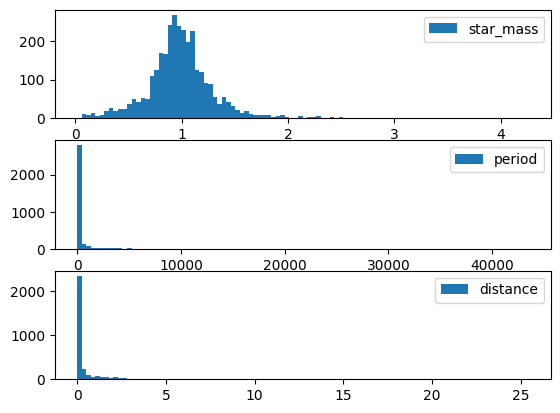

In [ ]:
fig, ax = plt.subplots(3,1)
ax[0].hist(final_features[:,0], bins = 100, label='star_mass');
ax[1].hist(final_features[:,1], bins = 100, label='period');
ax[2].hist(final_features[:,2], bins = 100, label='distance');
for i in range(3):
  ax[i].legend();

### Questions:
What do you notice about their distribution? Is there anything that might make the classification problem challenging?

Most of the distribution is centered around 1 solar mass, but there is a long tail out to masses of 4 solar masses. Furthermore, both period and distance appear to have severe outliers as per the data (long tails in the histograms which is confirmed by the min and max values above in the df.describe() output). This means we have data points that may be easily missed.

## 1.4 Check the distribution or counts of the target.

### Question:
This is a binary classification problem. Are the two outcomes equally probable?

In [ ]:
df.groupby('P_HABITABLE').count()

,S_MASS,P_PERIOD,P_DISTANCE
P_HABITABLE,,,
0,3119,3119,3119
1,52,52,52


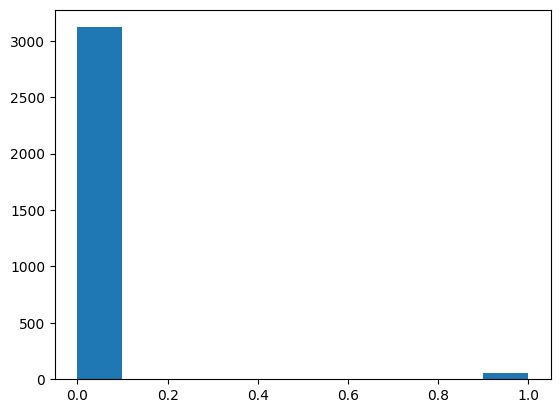

In [ ]:
plt.hist(targets);

ANSWER: No, we expect a highly biased sample

### Question:     
What kind of performance can we expect (qualitatively, is the information sufficient?) Do you expect to have latent (hidden) variables that might affect the outcome beyond those that we have?


We have a lot of data, but given the imbalance, I'm expecting high accuracy but low recall scores. I expect the DT to classify everything as "not habitable". Yes, I expect there are variables not included in our dataset that could contribute important information beyond what we are given.

# Problem 2: Perform Decision Tree Classification
## 2.1
a. Begin with a random train/test split. Make and 80/20 train test split, remember to use a random_state.

b. make a histogram or check the counts of the targets in the training and test set.

c. define your model

d. fit your model

e. make predictions for the test features

f. evaluate your model on the test targets using an accuracy score

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(final_features, targets,\
                                                test_size=0.2, random_state=2)

In [ ]:
Xtrain.shape, Xtest.shape

((2536, 3), (635, 3))

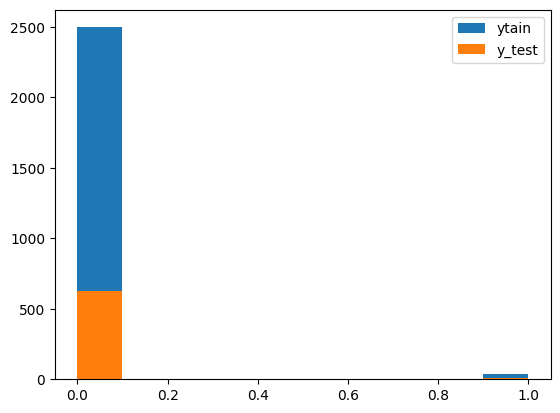

In [ ]:
plt.hist(ytrain, label='ytain')
plt.hist(ytest, label='y_test')
plt.legend();

In [ ]:
print('counts in test set', np.unique(ytest, return_counts=True))
print('counts in train set', np.unique(ytrain, return_counts=True))

counts in test set (array([0, 1]), array([623,  12]))
counts in train set (array([0, 1]), array([2496,   40]))


Let's pick the DT method (fixing random state) and build the model.

In [ ]:
model = DecisionTreeClassifier(random_state=5)

model.fit(Xtrain, ytrain)

DecisionTreeClassifier(random_state=5)

### Let's take a look at train/test scores.

In [ ]:
print(metrics.accuracy_score(ytrain, model.predict(Xtrain))) #train score

print(metrics.accuracy_score(ytest, model.predict(Xtest))) #test score

1.0
0.9826771653543307


### Question: Can you predict the accuracy score on the train set?

100%, like all the "unleashed" decision trees.

In [ ]:
df.columns[0:3]

Index(['S_MASS', 'P_PERIOD', 'P_DISTANCE'], dtype='object')

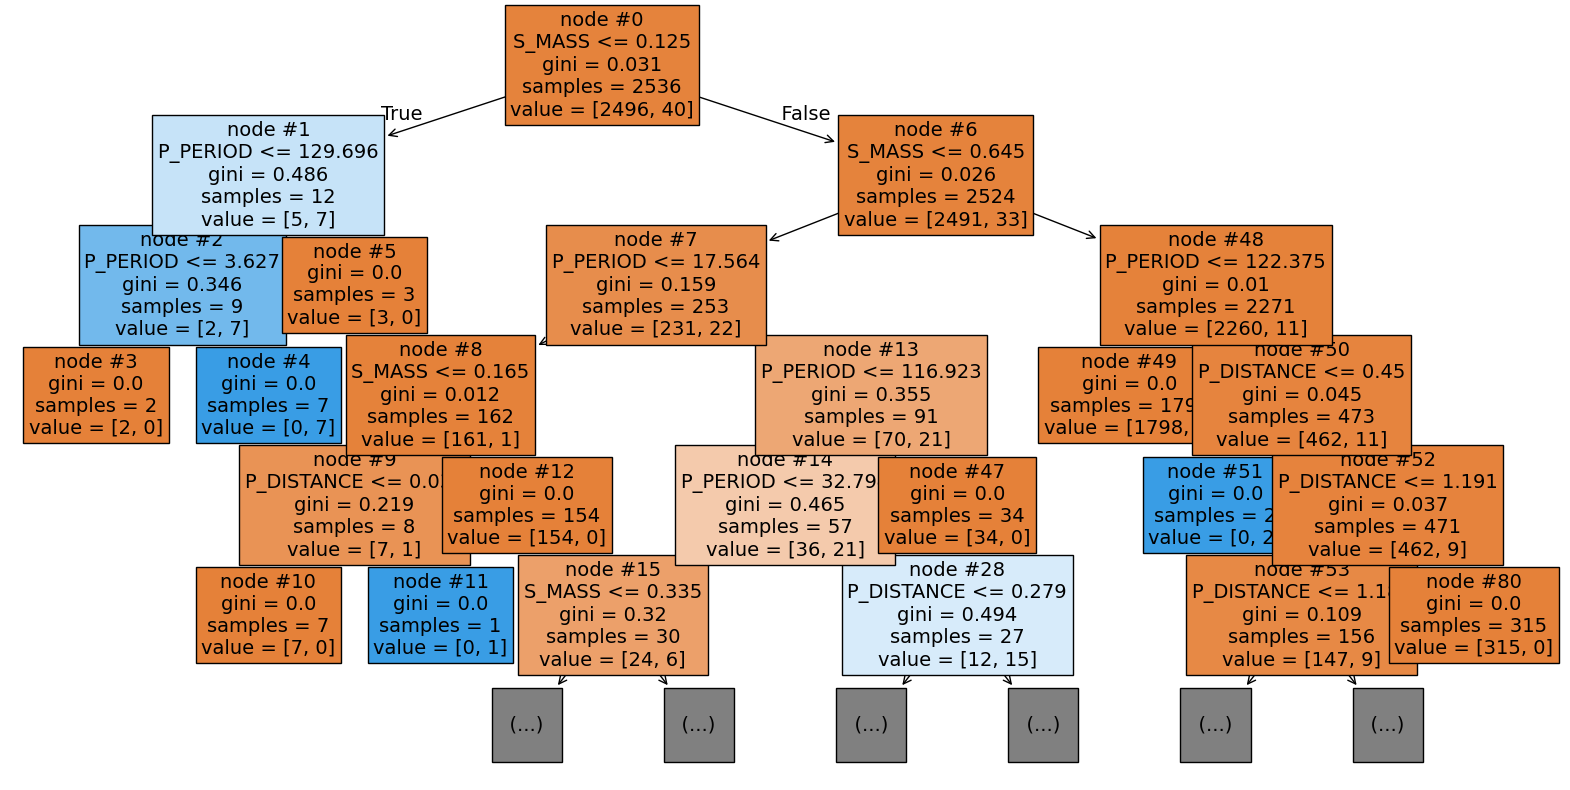

In [ ]:
plt.figure(figsize=(20,10))  # customize this size according to the size of your tree

tree.plot_tree(model, feature_names = df.columns[0:3],max_depth=5,\
                filled=True, node_ids=True, fontsize=14);

# Problem 3: Analysis
## 3.1 Plot the confusion matrix.

* Note that so far, we use the predictions on *one* test fold, so the numbers will refer to the test set only.

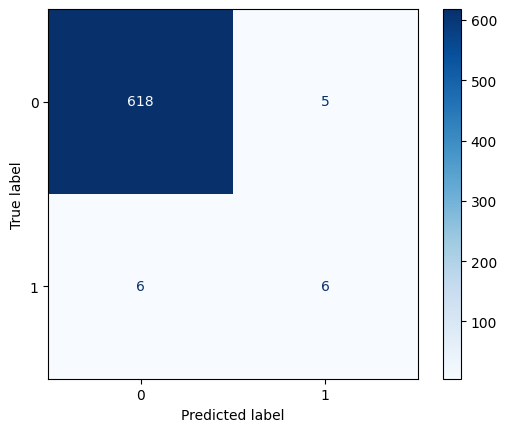

In [ ]:
ConfusionMatrixDisplay.from_estimator(model, Xtest, ytest, cmap='Blues')

## 3.2 Repeat steps in 2.1 but using a 50/50 train/test split, and a 85/15 train/test split.

Note: Be sure to define the variables that hold your other models by different names. We do not want to get our models mixed-up.

### Question:
What happens to the accuracy? Would you expect the accuracy to go up or down as your training set becomes larger?

In [ ]:
Xtrain_2, Xtest_2, ytrain_2, ytest_2 = train_test_split(final_features, targets,\
                                                test_size=0.5, random_state=2)

In [ ]:
print('counts in test set', np.unique(ytest_2, return_counts=True))
print('counts in train set', np.unique(ytrain_2, return_counts=True))

counts in test set (array([0, 1]), array([1564,   22]))
counts in train set (array([0, 1]), array([1555,   30]))


In [ ]:
model_2 = DecisionTreeClassifier(random_state=5)

In [ ]:
model_2.fit(Xtrain_2, ytrain_2)

DecisionTreeClassifier(random_state=5)

In [ ]:
ypred_2 = model_2.predict(Xtest_2)

In [ ]:
print(metrics.accuracy_score(ytrain_2, model.predict(Xtrain_2))) #train score
print(metrics.accuracy_score(ytest_2, ypred_2)) #test score

1.0
0.980453972257251


In [ ]:
Xtrain_3, Xtest_3, ytrain_3, ytest_3 = train_test_split(final_features, targets,\
                                                test_size=0.15, random_state=2)

In [ ]:
print('counts in test set', np.unique(ytest_3, return_counts=True))
print('counts in train set', np.unique(ytrain_3, return_counts=True))

counts in test set (array([0, 1]), array([464,  12]))
counts in train set (array([0, 1]), array([2655,   40]))


In [ ]:
model_3 = DecisionTreeClassifier(random_state=5)

In [ ]:
model_3.fit(Xtrain_3, ytrain_3)

DecisionTreeClassifier(random_state=5)

In [ ]:
ypred_3 = model_3.predict(Xtest_3)

In [ ]:
print(metrics.accuracy_score(ytrain_3, model.predict(Xtrain_3))) #train score
print(metrics.accuracy_score(ytest_3, ypred_3)) #test score

0.9988868274582561
0.9831932773109243


Initially one would have predicted that the training score where the DT used only 50% of the data to train would have a lower training score. But let's remember that we have highly imbalanced data set, and with only 50% of the data for training, it's possible that the training set didn't include any of the rare instances. So the training would have 100% accuracy. And if the 85/15 train test split included more of the rare instances, then this would allow for a training score less than 100% accuracy.

## 3.4  Implement two types of k-fold Cross Validation.

Note: remember to fix the random seed for exactly reproducible behavior.

a. Create two cross-validation generators. One using the 5 k-fold split like we've been doing in class. For the second one use the StratifiedKFold(). You will need to import it like this:

from sklearn.model_selection import StratifiedKFold

Then implement it with the same keywords as the KFold().

** STRATIFICATION ensures that the class distributions in each split resembles those of the
ENTIRE data set

b. Perform cross-validation two times, once using the KFold split and another using the StratifiedKFold. print the training and testing scores as usual and compare.

### Question:
Did changing the cross-validation generator affect the scores significantly?

In [ ]:
cv_standard = KFold(shuffle = True, n_splits = 5, random_state=5)

# STRATIFICATION ensures that the class distributions in each split resembles those of the
# entire data set

cv_stratified = StratifiedKFold(shuffle = True, n_splits = 5, random_state=5)


### The handy function cross\_validate provides the scores (specified by the chosen scoring parameter), in dictionary form.

In [ ]:
def cross_val_classification(model, ftr, tgt, cv, score_metric='accuracy'):
    scores = cross_validate(model, ftr, tgt, cv=cv, scoring = score_metric, \
                        return_train_score = True)
    test = scores['test_score']
    train = scores['train_score']

    print('Mean test scores:', test.mean(), '+/-', test.std())
    print('Mean train scores:', train.mean(), '+/-', train.std())
    return test, train

In [ ]:
scores_standard = cross_val_classification(model_3, final_features, targets, cv_standard, score_metric='accuracy')

Mean test scores: 0.9829697707344941 +/- 0.005592197136429461
Mean train scores: 1.0 +/- 0.0


In [ ]:
scores_stratified = cross_val_classification(model_3, final_features, targets, cv_stratified, score_metric='accuracy')

Mean test scores: 0.9839171365408976 +/- 0.005220440079229699
Mean train scores: 1.0 +/- 0.0


#### Question: are the differences between the two kinds of Kfold splits statistically significant?

No, because the difference is less than one standard deviation!

## 3.5 Let's now use recall as our scoring parameter.
### Question:
How would you evaluate the model based on the result from the recall scores vs the accuracy scores?

In [ ]:

scores_standard_recall = cross_val_classification(model_3, final_features, targets, cv_standard, score_metric='recall')

scores_strat_recall = cross_val_classification(model_3, final_features, targets, cv_stratified, score_metric='recall')

Mean test scores: 0.46823176823176826 +/- 0.16718680925895568
Mean train scores: 1.0 +/- 0.0
Mean test scores: 0.4654545454545455 +/- 0.16806138193878317
Mean train scores: 1.0 +/- 0.0


Unsurprisingly, the recall scores on the train set are perfect, but we see much lower recall scores on the test set! The differences between the two Kfold splits are also not statistically different.

# Problem 4:  Finally, plot the learning curves using the model with the 80/20 split and the stratified cv generator.

Learning curves are helpful in order to visualize the training scores vs the test scores, and how they vary as a function of data set size. They allow us to determine whether we have enough learning data, AND whether we have a high bias or high variance problem.

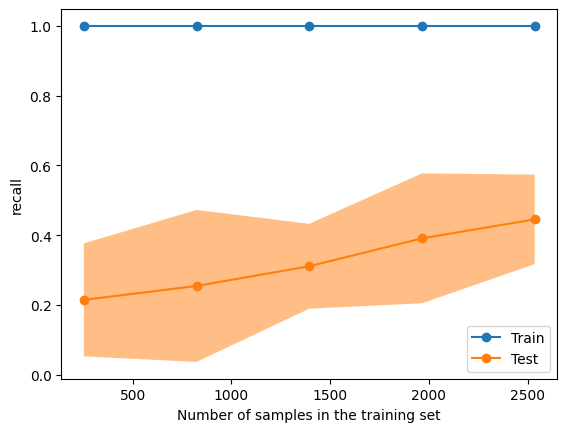

In [ ]:
common_params = {
    "X": final_features,
    "y": targets,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": cv_stratified,
    "score_type": "both",
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "recall",
}
LearningCurveDisplay.from_estimator(model, **common_params, scoring='recall')

# Problem 5. Conclusions: Is our Desicion Tree model suffering from high variance or high bias? What might you suggest for a next step and why?

While its obvious that we have very biased distribution of classes, the model suffers from high variance, as shown by the statistically significant gap between train and test scores using recall as the scoring metric. More data will help, as the slope of the test scores in the learning curve are on an upward trend.

I would first try to remove features to address the high variance (overfitting) keeping only stellar mass as a feature. I would choose this based on the ditribution of this feature. While the histogram of stellar mass has long tails, suggesting outliers, its distribution is nearly a normal distribution centered at 1.

Identifying habitable exoplanets in the habitable zone is a difficult task.